# Importing all the Libraries

### Core Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers

### NLP Libraries

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dinesh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dinesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dinesh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Others

In [3]:
import warnings
warnings.filterwarnings('ignore')

import evaluate
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [4]:
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

GPU available: True
GPU name: NVIDIA GeForce GTX 1650


# Data Input

In [5]:
input_labelled = pd.read_csv('C:/Users/Dinesh/Git_Hub/HostelFix-AI/data/data_input.csv')
input_data = pd.DataFrame(input_labelled)
df0 = input_data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   complaint      1381 non-null   object
 1   priority       1381 non-null   int64 
 2   parts          1381 non-null   object
 3   repair_person  1381 non-null   object
dtypes: int64(1), object(3)
memory usage: 43.3+ KB


In [6]:
df0.head(10)

,complaint,priority,parts,repair_person
0,need to provide the wire for clothes drying in...,1,No,Others
1,Room 394's trash bin lid is broken,3,Yes,Others
2,Normal drinking water is not coming on ground ...,4,No,"Yes, A plumber"
3,Room 375's light fixture hums,2,Yes,"Yes, An electrician"
4,Hallway filled with smoke due to short circuit!,5,No,"Yes, An electrician"
5,Bathroom tap in Room 306 drips constantly,3,Yes,"Yes, A plumber"
6,the water issue is in 1st floor west side,3,No,"Yes, A plumber"
7,Room 423's closet is infested with termites,4,Yes,"Yes, A carpenter"
8,Dampness leading to mold in bathrooms or rooms.,3,No,"Yes, A plumber"
9,Room 220's window doesn't latch properly,2,Yes,"Yes, A carpenter"


In [7]:
input_raw_chat = pd.read_csv('C:/Users/Dinesh/Git_Hub/HostelFix-AI/data/raw_text_input.csv')
input1 = pd.DataFrame(input_raw_chat)
df = input1
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657 entries, 0 to 656
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   complaint  657 non-null    object
dtypes: object(1)
memory usage: 5.3+ KB


In [8]:
df.head(10)

,complaint
0,"29/08/24, 5:37 pm - +91 85907 34302: @91962968..."
1,"29/08/24, 5:47 pm - +91 89544 46533: @91962968..."
2,"29/08/24, 6:17 pm - +91 70911 94066: @91962968..."
3,"29/08/24, 8:40 pm - +91 62644 98745: Please do..."
4,"31/08/24, 9:36 am - +91 97893 20825: @91962968..."
5,"31/08/24, 10:03 am - +91 70911 94066: @9196296..."
6,"31/08/24, 12:25 pm - +91 96870 26360: @9196296..."
7,@919629686866 sir please fix the flush as soon...
8,"31/08/24, 8:32 pm - +91 97893 20825: Normal wa..."
9,"31/08/24, 8:35 pm - +91 96870 26360: @91962968..."


# Regular Expressions
### Sample Date & time formats are : 12/03/2025, 9:45 am -
### Sample Phone numbers formats are : +91 98765 43210 or 9876543210
### And for the Sender names (optional) : Anything before the colon is treated as the sender name

In [9]:
pattern_date_time = re.compile(
    r"^(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4},?\s*\d{1,2}:\d{2}(?:\s*[APMapm]{2})?\s*-\s*)?"
)

In [10]:
df["complaint"] = df["complaint"].apply(lambda x: re.sub(pattern_date_time, "", str(x)).strip())
df.head(10)

,complaint
0,+91 85907 34302: @919629686866 no water in bat...
1,+91 89544 46533: @919629686866 no water in 3rd...
2,+91 70911 94066: @919629686866 no water in ba...
3,+91 62644 98745: Please do something about the...
4,"+91 97893 20825: @919629686866 sir, Normal wat..."
5,+91 70911 94066: @919629686866 sir foot light ...
6,+91 96870 26360: @919629686866 sir no water in...
7,@919629686866 sir please fix the flush as soon...
8,+91 97893 20825: Normal water is not coming in...
9,"+91 96870 26360: @919629686866 sir , normal wa..."


In [11]:
pattern_phone_number = re.compile(
    r"(?:\+?\d{1,4}[\s-]?\d{5}[\s-]?\d{5}|[^:]+)?:\s*"
)

In [12]:
df["complaint"] = df["complaint"].apply(lambda x: re.sub(pattern_phone_number, "", str(x)).strip())
df.head(10)

,complaint
0,@919629686866 no water in bathroom 1st floor
1,@919629686866 no water in 3rd floor
2,@919629686866 no water in bathroom on 3rd floor
3,Please do something about the water problem
4,"@919629686866 sir, Normal water not coming for..."
5,@919629686866 sir foot light is not working in...
6,@919629686866 sir no water in water cooler 2nd...
7,@919629686866 sir please fix the flush as soon...
8,"Normal water is not coming in ground floor,1st..."
9,"@919629686866 sir , normal water is not availa..."


In [13]:
df["complaint"] = df["complaint"].apply(lambda x: re.sub(r"@\d+", "", x).strip())
df.head(10)

,complaint
0,no water in bathroom 1st floor
1,no water in 3rd floor
2,no water in bathroom on 3rd floor
3,Please do something about the water problem
4,"sir, Normal water not coming for 2 days in 1st..."
5,sir foot light is not working in room no-249. ...
6,sir no water in water cooler 2nd floor
7,sir please fix the flush as soon as possible t...
8,"Normal water is not coming in ground floor,1st..."
9,"sir , normal water is not available and I alre..."


In [14]:
df = df0
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   complaint      1381 non-null   object
 1   priority       1381 non-null   int64 
 2   parts          1381 non-null   object
 3   repair_person  1381 non-null   object
dtypes: int64(1), object(3)
memory usage: 43.3+ KB


In [15]:
print(df.columns)
df.head(15)

Index(['complaint', 'priority', 'parts', 'repair_person'], dtype='object')


,complaint,priority,parts,repair_person
0,need to provide the wire for clothes drying in...,1,No,Others
1,Room 394's trash bin lid is broken,3,Yes,Others
2,Normal drinking water is not coming on ground ...,4,No,"Yes, A plumber"
3,Room 375's light fixture hums,2,Yes,"Yes, An electrician"
4,Hallway filled with smoke due to short circuit!,5,No,"Yes, An electrician"
5,Bathroom tap in Room 306 drips constantly,3,Yes,"Yes, A plumber"
6,the water issue is in 1st floor west side,3,No,"Yes, A plumber"
7,Room 423's closet is infested with termites,4,Yes,"Yes, A carpenter"
8,Dampness leading to mold in bathrooms or rooms.,3,No,"Yes, A plumber"
9,Room 220's window doesn't latch properly,2,Yes,"Yes, A carpenter"


## Data Distribution

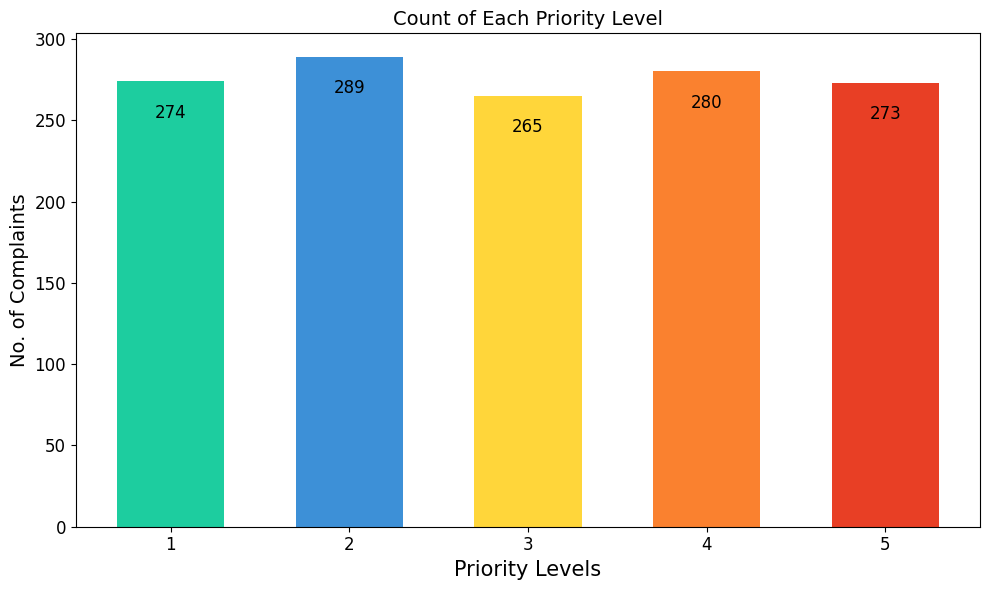

In [16]:
priority_counts = df['priority'].value_counts().sort_index()

colors = ['#1DCD9F','#3D90D7','#FFD63A','#FA812F','#E83F25']

plt.figure(figsize=(10, 6))
bars = plt.bar(priority_counts.index, priority_counts.values, color=colors, width=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval - 25, int(yval), ha='center', va='bottom', fontsize=12)

plt.xlabel('Priority Levels', fontsize=15)
plt.ylabel('No. of Complaints', fontsize=14)
plt.title('Count of Each Priority Level', fontsize=14)
plt.xticks(priority_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

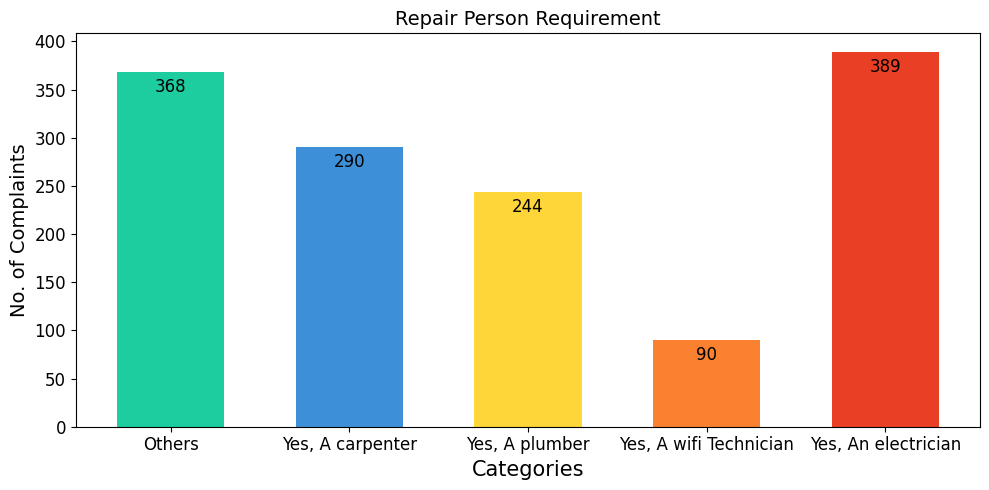

In [17]:
priority_counts = df['repair_person'].value_counts().sort_index()

colors = ['#1DCD9F','#3D90D7','#FFD63A','#FA812F','#E83F25']

plt.figure(figsize=(10, 5))
bars = plt.bar(priority_counts.index, priority_counts.values, color=colors, width=0.6)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval - 25, int(yval), ha='center', va='bottom', fontsize=12)

plt.xlabel('Categories', fontsize=15)
plt.ylabel('No. of Complaints', fontsize=14)
plt.title('Repair Person Requirement', fontsize=14)
plt.xticks(priority_counts.index, fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

## TF-IDF Vectorizer

In [18]:
df_lr = input_data
df_lr

,complaint,priority,parts,repair_person
0,need to provide the wire for clothes drying in...,1,No,Others
1,Room 394's trash bin lid is broken,3,Yes,Others
2,Normal drinking water is not coming on ground ...,4,No,"Yes, A plumber"
3,Room 375's light fixture hums,2,Yes,"Yes, An electrician"
4,Hallway filled with smoke due to short circuit!,5,No,"Yes, An electrician"
...,...,...,...,...
1376,INFESTED DRINKING WATER supply,5,No,"Yes, A plumber"
1377,BEE HIVE blocking emergency exit near Room 144!,5,No,Others
1378,",need a roof for cycle parking in opal",1,No,Others
1379,Room 72’s wall has a faint pencil mark – erasu...,1,No,Others


In [19]:
df_lr = df_lr[df_lr['priority'].notnull()]
df_lr['priority'] = df_lr['priority'].astype(int)

In [20]:
# Converting priority from 1-5 to 0-4 for easier model trainig 
df_lr['label'] = df_lr['priority'] - 1
df_lr

,complaint,priority,parts,repair_person,label
0,need to provide the wire for clothes drying in...,1,No,Others,0
1,Room 394's trash bin lid is broken,3,Yes,Others,2
2,Normal drinking water is not coming on ground ...,4,No,"Yes, A plumber",3
3,Room 375's light fixture hums,2,Yes,"Yes, An electrician",1
4,Hallway filled with smoke due to short circuit!,5,No,"Yes, An electrician",4
...,...,...,...,...,...
1376,INFESTED DRINKING WATER supply,5,No,"Yes, A plumber",4
1377,BEE HIVE blocking emergency exit near Room 144!,5,No,Others,4
1378,",need a roof for cycle parking in opal",1,No,Others,0
1379,Room 72’s wall has a faint pencil mark – erasu...,1,No,Others,0


## Data Train Test Split

In [21]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    df_lr['complaint'], df_lr['priority'], test_size=0.2, random_state=42, stratify=df['priority']
)

In [22]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(X_train_lr)
X_test_tfidf = vectorizer.transform(X_test_lr)

## Logistic Regression Classifier

In [23]:
LRClassifier = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs', multi_class='auto')
LRClassifier.fit(X_train_tfidf, y_train_lr)

LogisticRegression(class_weight='balanced', max_iter=1000, multi_class='auto')

In [24]:
y_pred_lr = LRClassifier.predict(X_test_tfidf)

## Accuracy for Logistic Regression

In [25]:
accuracy = accuracy_score(y_test_lr, y_pred_lr)
print(f"\n Accuracy: {accuracy:.4f}\n")


 Accuracy: 0.6029



In [26]:
print("\n Classification Report: \n ")
print(classification_report(y_test_lr, y_pred_lr, target_names=[str(i+1) for i in range(5)]))


 Classification Report: 
 
              precision    recall  f1-score   support

           1       0.55      0.75      0.63        55
           2       0.42      0.43      0.43        58
           3       0.58      0.34      0.43        53
           4       0.76      0.68      0.72        56
           5       0.73      0.82      0.77        55

    accuracy                           0.60       277
   macro avg       0.61      0.60      0.59       277
weighted avg       0.61      0.60      0.59       277



## Confusion Matrix

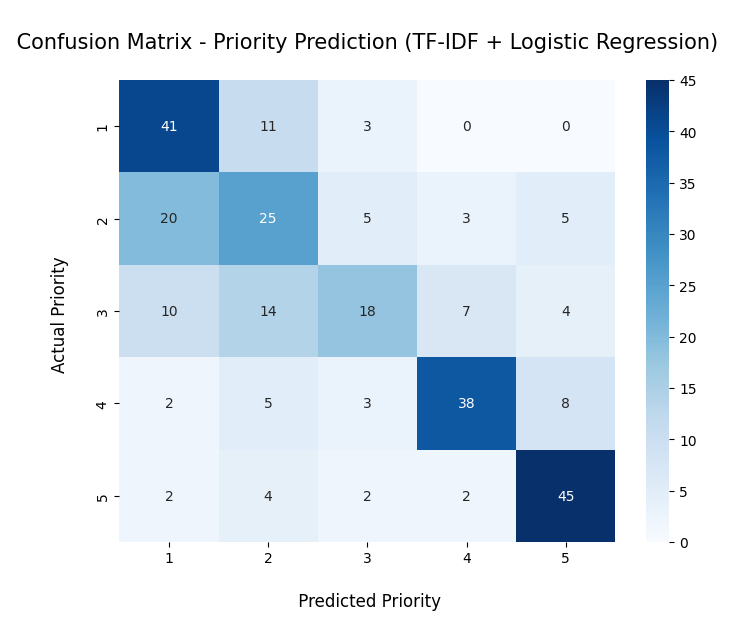

In [27]:
cm = confusion_matrix(y_test_lr, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i+1) for i in range(5)], 
            yticklabels=[str(i+1) for i in range(5)])
plt.xlabel("\n Predicted Priority", fontsize=12)
plt.ylabel("Actual Priority \n", fontsize=12)
plt.title(" \n Confusion Matrix - Priority Prediction (TF-IDF + Logistic Regression) \n ", fontsize=15)
plt.show()

# Bert Tokenizer + Fine-tuning DistilBERT

In [28]:
df_bert = input_data
df_bert.info()
df_bert

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1381 entries, 0 to 1380
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   complaint      1381 non-null   object
 1   priority       1381 non-null   int64 
 2   parts          1381 non-null   object
 3   repair_person  1381 non-null   object
dtypes: int64(1), object(3)
memory usage: 43.3+ KB


,complaint,priority,parts,repair_person
0,need to provide the wire for clothes drying in...,1,No,Others
1,Room 394's trash bin lid is broken,3,Yes,Others
2,Normal drinking water is not coming on ground ...,4,No,"Yes, A plumber"
3,Room 375's light fixture hums,2,Yes,"Yes, An electrician"
4,Hallway filled with smoke due to short circuit!,5,No,"Yes, An electrician"
...,...,...,...,...
1376,INFESTED DRINKING WATER supply,5,No,"Yes, A plumber"
1377,BEE HIVE blocking emergency exit near Room 144!,5,No,Others
1378,",need a roof for cycle parking in opal",1,No,Others
1379,Room 72’s wall has a faint pencil mark – erasu...,1,No,Others


In [29]:
target_col = 'priority'

In [30]:
le = LabelEncoder()
df_bert['label'] = le.fit_transform(df_bert[target_col])
num_labels = len(le.classes_)

## Data Train Test Split

In [31]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['complaint'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

In [32]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=128)

In [33]:
train_dataset = Dataset.from_dict({**train_encodings, 'label': train_labels})
test_dataset = Dataset.from_dict({**test_encodings, 'label': test_labels})

In [34]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluation Metrics

In [35]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'precision': p,
        'recall': r,
        'f1': f1
    }

In [36]:
training_args = TrainingArguments(
    output_dir='./priority_model',
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    save_total_limit=2
)

In [37]:
metric = evaluate.load("accuracy")

In [38]:
early_stop_callback = EarlyStoppingCallback(early_stopping_patience=2)

In [39]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[early_stop_callback]
)


In [40]:
trainer.train()

# ==== Evaluate ====
results = trainer.evaluate()
print("Final Evaluation on Test Set:", results)

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.183584,0.534296,0.547833,0.534296,0.476129
2,No log,0.912022,0.642599,0.632779,0.642599,0.624836
3,No log,0.792464,0.700361,0.702635,0.700361,0.690661
4,No log,0.712611,0.750903,0.747148,0.750903,0.743216
5,No log,0.645815,0.765343,0.760933,0.765343,0.761432
6,No log,0.637951,0.787004,0.786643,0.787004,0.785787
7,No log,0.647769,0.765343,0.762980,0.765343,0.763143
8,0.683500,0.658565,0.787004,0.785127,0.787004,0.784502


Final Evaluation on Test Set: {'eval_loss': 0.6379508972167969, 'eval_accuracy': 0.7870036101083032, 'eval_precision': 0.7866431606287864, 'eval_recall': 0.7870036101083032, 'eval_f1': 0.7857872482173976, 'eval_runtime': 0.7672, 'eval_samples_per_second': 361.036, 'eval_steps_per_second': 23.461, 'epoch': 8.0}


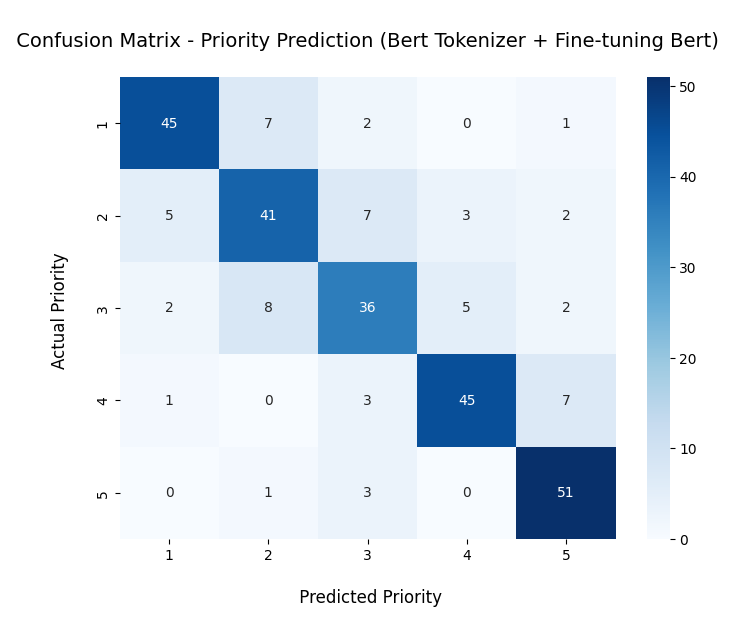


 Classification Report: 

              precision    recall  f1-score   support

           1       0.85      0.82      0.83        55
           2       0.72      0.71      0.71        58
           3       0.71      0.68      0.69        53
           4       0.85      0.80      0.83        56
           5       0.81      0.93      0.86        55

    accuracy                           0.79       277
   macro avg       0.79      0.79      0.79       277
weighted avg       0.79      0.79      0.79       277



In [45]:
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
class_names = [str(i+1) for i in range(num_labels)]  # Convert 0→"1", 1→"2", etc.

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("\n Predicted Priority", fontsize=12)
plt.ylabel("Actual Priority \n", fontsize=12)
plt.title(" \n Confusion Matrix - Priority Prediction (Bert Tokenizer + Fine-tuning Bert) \n ", fontsize=14)
plt.show()

print("\n Classification Report: \n")
print(classification_report(test_labels, y_pred, target_names=class_names))

## Custom Input 

In [47]:
def predict_priority(text, model, tokenizer, label_shift=1):
    model.eval()
    device = model.device  

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}  # Move inputs to same device

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    return predicted_class + label_shift

In [52]:
custom_complaint = input("Enter your hostel complaint: ")
predicted = predict_priority(custom_complaint, model, tokenizer)
print(f"Predicted Priority: {predicted}")

Enter your hostel complaint:  Wifi is not working properly and needs fixing


Predicted Priority: 4


In [51]:
model.save_pretrained("priority_distilbert_model")
tokenizer.save_pretrained("priority_distilbert_tokenizer")

('priority_distilbert_tokenizer\\tokenizer_config.json',
 'priority_distilbert_tokenizer\\special_tokens_map.json',
 'priority_distilbert_tokenizer\\vocab.txt',
 'priority_distilbert_tokenizer\\added_tokens.json',
 'priority_distilbert_tokenizer\\tokenizer.json')